In [100]:
import pandas as pd
import re
from sklearn.model_selection import train_test_split

df = pd.read_csv("amazonreviews.tsv", sep="\t")  # columns: label, review

In [101]:
print(df.head())

  label                                             review
0   pos  Stuning even for the non-gamer: This sound tra...
1   pos  The best soundtrack ever to anything.: I'm rea...
2   pos  Amazing!: This soundtrack is my favorite music...
3   pos  Excellent Soundtrack: I truly like this soundt...
4   pos  Remember, Pull Your Jaw Off The Floor After He...


In [102]:
print(df.shape)

(10000, 2)


In [103]:
print(df["label"].value_counts())

label
neg    5097
pos    4903
Name: count, dtype: int64


In [104]:

# Basic cleaning
def clean_text(text):
    text = text.lower().strip()
    text = re.sub(r"<.*?>", " ", text)           # remove HTML tags
    text = re.sub(r"[^a-z\s]", " ", text)      # keep only letters/spaces
    text = re.sub(r"\s+", " ", text)        # normalize spaces
    return text

df["clean_review"] = df["review"].astype(str).apply(clean_text)

In [105]:
# Optional:remove the  stopwords and lemmatize
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

nltk.download("stopwords")
nltk.download("wordnet")

stop_words = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()

def preprocess_tokens(text):
    tokens = [w for w in text.split() if w not in stop_words]
    tokens = [lemmatizer.lemmatize(w) for w in tokens]
    return " ".join(tokens)

df["clean_review"] = df["clean_review"].apply(preprocess_tokens)


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\RITHIKA\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\RITHIKA\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [106]:
# Quick check
print(df[["label", "review", "clean_review"]].head())

  label                                             review  \
0   pos  Stuning even for the non-gamer: This sound tra...   
1   pos  The best soundtrack ever to anything.: I'm rea...   
2   pos  Amazing!: This soundtrack is my favorite music...   
3   pos  Excellent Soundtrack: I truly like this soundt...   
4   pos  Remember, Pull Your Jaw Off The Floor After He...   

                                        clean_review  
0  stuning even non gamer sound track beautiful p...  
1  best soundtrack ever anything reading lot revi...  
2  amazing soundtrack favorite music time hand in...  
3  excellent soundtrack truly like soundtrack enj...  
4  remember pull jaw floor hearing played game kn...  


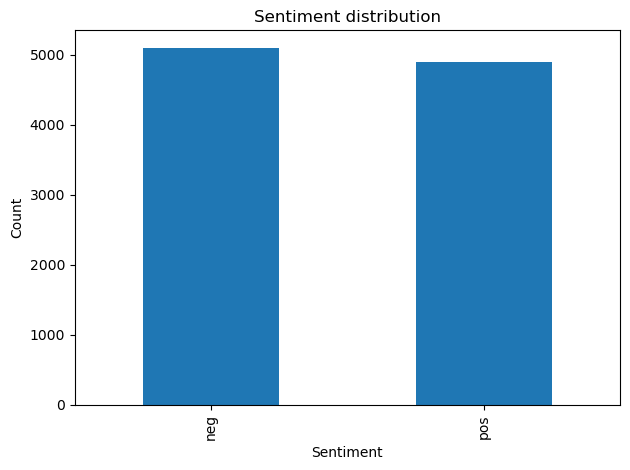

In [107]:
#2. Exploratory analysis
#Sentiment distribution

import matplotlib.pyplot as plt
df["label"].value_counts().plot(kind="bar", title="Sentiment distribution")
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.tight_layout()
plt.show()


In [108]:
df["length"] = df["clean_review"].apply(lambda x: len(x.split()))
print(df["length"].describe())

count    10000.000000
mean        40.147200
std         21.814388
min          4.000000
25%         22.000000
50%         36.000000
75%         55.000000
max        143.000000
Name: length, dtype: float64


In [109]:
#Most common words per class

from collections import Counter

def get_top_words(subset, n=20):
    all_words = " ".join(subset).split()
    return Counter(all_words).most_common(n)

pos_top = get_top_words(df[df["label"]=="pos"]["clean_review"])
neg_top = get_top_words(df[df["label"]=="neg"]["clean_review"])
print("Top positive:", pos_top[:20])
print("Top negative:", neg_top[:20])


Top positive: [('book', 3933), ('great', 2137), ('one', 1997), ('good', 1671), ('read', 1628), ('like', 1342), ('movie', 1330), ('time', 1189), ('love', 1045), ('would', 956), ('get', 948), ('well', 947), ('story', 875), ('really', 832), ('best', 813), ('first', 724), ('make', 711), ('year', 703), ('work', 701), ('much', 664)]
Top negative: [('book', 3760), ('one', 2193), ('movie', 1784), ('like', 1592), ('would', 1465), ('time', 1321), ('get', 1299), ('read', 1275), ('good', 1163), ('even', 910), ('buy', 842), ('really', 783), ('much', 782), ('work', 781), ('story', 781), ('make', 776), ('money', 767), ('bad', 764), ('first', 760), ('product', 707)]


In [110]:
pip install wordcloud

Note: you may need to restart the kernel to use updated packages.


In [111]:
from wordcloud import WordCloud

pos_text = " ".join(df[df["label"]=="pos"]["clean_review"])
neg_text = " ".join(df[df["label"]=="neg"]["clean_review"])

wc_pos = WordCloud(width=800, height=400, background_color="white").generate(pos_text)
wc_neg = WordCloud(width=800, height=400, background_color="white").generate(neg_text)


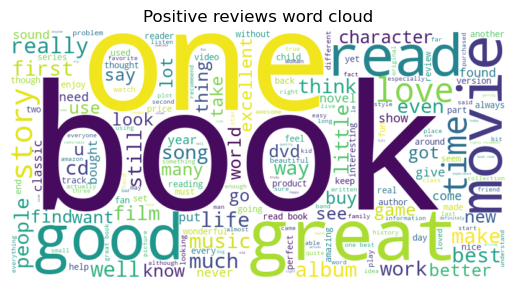

In [112]:
plt.imshow(wc_pos, interpolation="bilinear")
plt.axis("off")
plt.title("Positive reviews word cloud")
plt.show()

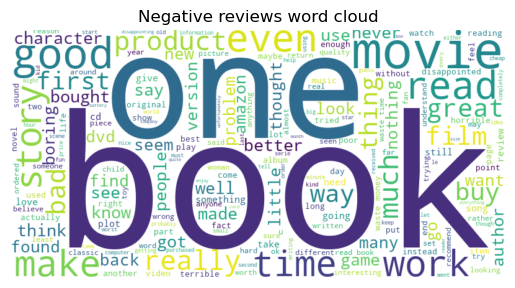

In [113]:
plt.imshow(wc_neg, interpolation="bilinear")
plt.axis("off")
plt.title("Negative reviews word cloud")
plt.show()


In [114]:
#3. Feature extraction
from sklearn.feature_extraction.text import TfidfVectorizer

X = df["clean_review"]
y = df["label"].map({"neg":0, "pos":1})  

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

tfidf = TfidfVectorizer(
    max_features=20000,
    ngram_range=(1,2),     
    min_df=2
)

X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)


In [115]:
print("Train TF-IDF shape:", X_train_tfidf.shape)
print("Test TF-IDF shape:", X_test_tfidf.shape)

Train TF-IDF shape: (8000, 20000)
Test TF-IDF shape: (2000, 20000)


In [116]:
#4. Model development
#Logistic Regression

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

log_reg = LogisticRegression(max_iter=1000, n_jobs=-1)
cv_scores = cross_val_score(log_reg, X_train_tfidf, y_train, cv=5, scoring="f1")
print("LogReg CV F1:", cv_scores.mean())

log_reg.fit(X_train_tfidf, y_train)


LogReg CV F1: 0.8566036527671634


LogisticRegression(max_iter=1000, n_jobs=-1)

In [117]:
# Linear SVM --- very strong for text

from sklearn.svm import LinearSVC

svm_clf = LinearSVC()
cv_scores_svm = cross_val_score(svm_clf, X_train_tfidf, y_train, cv=5, scoring="f1")
print("SVM CV F1:", cv_scores_svm.mean())

svm_clf.fit(X_train_tfidf, y_train)

C:\Users\RITHIKA\anaconda3\Lib\site-packages\sklearn\svm\_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
C:\Users\RITHIKA\anaconda3\Lib\site-packages\sklearn\svm\_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
C:\Users\RITHIKA\anaconda3\Lib\site-packages\sklearn\svm\_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
C:\Users\RITHIKA\anaconda3\Lib\site-packages\sklearn\svm\_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
C:\Users\RITHIKA\anaconda3\Lib\site-packages\sklearn

SVM CV F1: 0.8585309814805122


C:\Users\RITHIKA\anaconda3\Lib\site-packages\sklearn\svm\_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


LinearSVC()

In [118]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, f1_score, precision_score, recall_score,
classification_report, confusion_matrix)

log_reg = LogisticRegression(max_iter=1000, n_jobs=-1)

# hyperparameter tuning with GridSearchCV
param_grid = {"C": [0.1, 1, 3, 10]}
grid = GridSearchCV(
    log_reg,
    param_grid,
    cv=5,
    scoring="f1",
    n_jobs=-1,
    verbose=1
)
grid.fit(X_train_tfidf, y_train)

best_lr = grid.best_estimator_
print("Best C:", grid.best_params_)

# Fit best model on full training data
best_lr.fit(X_train_tfidf, y_train)


Fitting 5 folds for each of 4 candidates, totalling 20 fits
Best C: {'C': 3}


LogisticRegression(C=3, max_iter=1000, n_jobs=-1)

In [119]:
#5. Evaluation
#Use the held‑out test set and multiple metrics.


from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix

def evaluate(model, X_tr, y_tr, X_te, y_te, name="Model"):
    y_pred_tr = model.predict(X_tr)
    y_pred_te = model.predict(X_te)
    print(f"{name} train accuracy:", accuracy_score(y_tr, y_pred_tr))
    print(f"{name} test accuracy:", accuracy_score(y_te, y_pred_te))
    print(f"{name} test F1:", f1_score(y_te, y_pred_te))
    print(classification_report(y_te, y_pred_te))

evaluate(best_lr, X_train_tfidf, y_train, X_test_tfidf, y_test,
         name="Logistic Regression (tuned)")
evaluate(svm_clf, X_train_tfidf, y_train, X_test_tfidf, y_test,
         name="Linear SVM")

cm = confusion_matrix(y_test, svm_clf.predict(X_test_tfidf))
print(cm)


Logistic Regression (tuned) train accuracy: 0.97675
Logistic Regression (tuned) test accuracy: 0.8565
Logistic Regression (tuned) test F1: 0.85334695963209
              precision    recall  f1-score   support

           0       0.86      0.86      0.86      1019
           1       0.86      0.85      0.85       981

    accuracy                           0.86      2000
   macro avg       0.86      0.86      0.86      2000
weighted avg       0.86      0.86      0.86      2000

Linear SVM train accuracy: 0.997875
Linear SVM test accuracy: 0.843
Linear SVM test F1: 0.838974358974359
              precision    recall  f1-score   support

           0       0.84      0.85      0.85      1019
           1       0.84      0.83      0.84       981

    accuracy                           0.84      2000
   macro avg       0.84      0.84      0.84      2000
weighted avg       0.84      0.84      0.84      2000

[[868 151]
 [163 818]]


In [120]:
#6. Business interpretation
def predict_sentiment(review_text, model, vectorizer):
    text = preprocess_tokens(clean_text(review_text))
    X_vec = vectorizer.transform([text])
    pred = model.predict(X_vec)[0]
    label = "positive" if pred == 1 else "negative"
    return label

print(predict_sentiment("I absolutely loved this product!", best_lr, tfidf))
print(predict_sentiment("Worst purchase ever, very disappointed.", best_lr, tfidf))

positive
negative


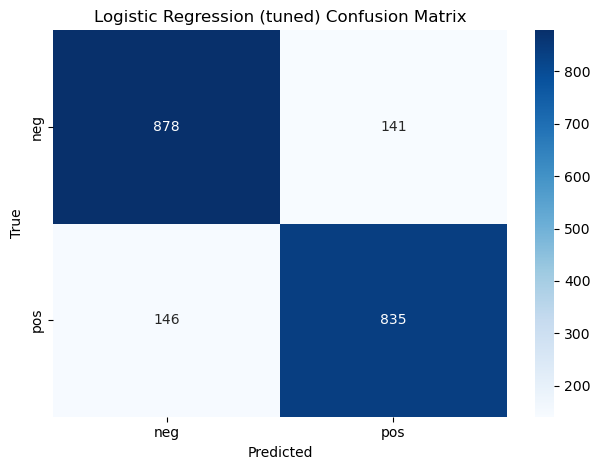

In [121]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

y_pred_test = best_lr.predict(X_test_tfidf)
cm = confusion_matrix(y_test, y_pred_test)

sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["neg","pos"],
            yticklabels=["neg","pos"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Logistic Regression (tuned) Confusion Matrix")
plt.tight_layout()
plt.show()


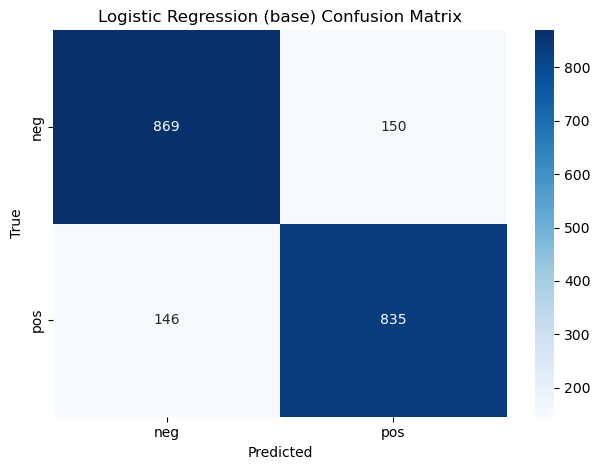

In [122]:
log_reg.fit(X_train_tfidf, y_train)  # fit base model

y_pred_test = log_reg.predict(X_test_tfidf)
cm = confusion_matrix(y_test, y_pred_test)

sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["neg","pos"],
            yticklabels=["neg","pos"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Logistic Regression (base) Confusion Matrix")
plt.tight_layout()
plt.show()


In [123]:
# Basic
import pandas as pd
import numpy as np

# Preprocessing
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Sklearn
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

# Word2Vec
from gensim.models import Word2Vec

nltk.download('stopwords')
nltk.download('wordnet')


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\RITHIKA\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\RITHIKA\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [124]:
df = df[['label', 'review']]             # change column names if needed
df.dropna(inplace=True)

print(df.head())

  label                                             review
0   pos  Stuning even for the non-gamer: This sound tra...
1   pos  The best soundtrack ever to anything.: I'm rea...
2   pos  Amazing!: This soundtrack is my favorite music...
3   pos  Excellent Soundtrack: I truly like this soundt...
4   pos  Remember, Pull Your Jaw Off The Floor After He...


In [125]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    tokens = text.split()
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    return " ".join(tokens)

df['clean_text'] = df['review'].apply(preprocess_text)


In [126]:
X_train, X_test, y_train, y_test = train_test_split(
    df['clean_text'], df['label'], 
    test_size=0.2, 
    random_state=42
)

In [127]:
tfidf = TfidfVectorizer(max_features=5000)

X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)


In [128]:
lr = LogisticRegression(max_iter=1000)

# Cross-validation
cv_scores = cross_val_score(lr, X_train_tfidf, y_train, cv=5)
print("Logistic Regression CV Accuracy:", cv_scores.mean())

# Hyperparameter tuning
param_grid = {'C': [0.01, 0.1, 1, 10]}

grid_lr = GridSearchCV(LogisticRegression(max_iter=1000), 
                       param_grid, 
                       cv=5)
grid_lr.fit(X_train_tfidf, y_train)

print("Best Parameters:", grid_lr.best_params_)

# Evaluation
y_pred_lr = grid_lr.predict(X_test_tfidf)

print("Accuracy:", accuracy_score(y_test, y_pred_lr))
print(classification_report(y_test, y_pred_lr))


Logistic Regression CV Accuracy: 0.849625
Best Parameters: {'C': 1}
Accuracy: 0.8465
              precision    recall  f1-score   support

         neg       0.85      0.85      0.85      1037
         pos       0.84      0.84      0.84       963

    accuracy                           0.85      2000
   macro avg       0.85      0.85      0.85      2000
weighted avg       0.85      0.85      0.85      2000



In [129]:
svm = LinearSVC()

# Cross-validation
cv_scores_svm = cross_val_score(svm, X_train_tfidf, y_train, cv=5)
print("SVM CV Accuracy:", cv_scores_svm.mean())

# Hyperparameter tuning
param_grid_svm = {'C': [0.01, 0.1, 1, 10]}

grid_svm = GridSearchCV(LinearSVC(), 
                        param_grid_svm, 
                        cv=5)
grid_svm.fit(X_train_tfidf, y_train)

print("Best Parameters:", grid_svm.best_params_)

# Evaluation
y_pred_svm = grid_svm.predict(X_test_tfidf)

print("Accuracy:", accuracy_score(y_test, y_pred_svm))
print(classification_report(y_test, y_pred_svm))


C:\Users\RITHIKA\anaconda3\Lib\site-packages\sklearn\svm\_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
C:\Users\RITHIKA\anaconda3\Lib\site-packages\sklearn\svm\_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
C:\Users\RITHIKA\anaconda3\Lib\site-packages\sklearn\svm\_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
C:\Users\RITHIKA\anaconda3\Lib\site-packages\sklearn\svm\_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
C:\Users\RITHIKA\anaconda3\Lib\site-packages\sklearn

SVM CV Accuracy: 0.83625


C:\Users\RITHIKA\anaconda3\Lib\site-packages\sklearn\svm\_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
C:\Users\RITHIKA\anaconda3\Lib\site-packages\sklearn\svm\_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
C:\Users\RITHIKA\anaconda3\Lib\site-packages\sklearn\svm\_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
C:\Users\RITHIKA\anaconda3\Lib\site-packages\sklearn\svm\_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
C:\Users\RITHIKA\anaconda3\Lib\site-packages\sklearn

Best Parameters: {'C': 0.1}
Accuracy: 0.848
              precision    recall  f1-score   support

         neg       0.86      0.85      0.85      1037
         pos       0.84      0.85      0.84       963

    accuracy                           0.85      2000
   macro avg       0.85      0.85      0.85      2000
weighted avg       0.85      0.85      0.85      2000



In [130]:
tokenized_text = [text.split() for text in df['clean_text']]

w2v_model = Word2Vec(
    sentences=tokenized_text,
    vector_size=100,
    window=5,
    min_count=2,
    workers=4
)


Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'


In [131]:
def get_sentence_embedding(text):
    words = text.split()
    word_vectors = [w2v_model.wv[word] for word in words if word in w2v_model.wv]
    if len(word_vectors) == 0:
        return np.zeros(100)
    return np.mean(word_vectors, axis=0)

X_w2v = np.array([get_sentence_embedding(text) for text in df['clean_text']])


In [132]:
X_train_w2v, X_test_w2v, y_train, y_test = train_test_split(
    X_w2v, df['label'], test_size=0.2, random_state=42
)

lr_w2v = LogisticRegression(max_iter=1000)
lr_w2v.fit(X_train_w2v, y_train)

y_pred_w2v = lr_w2v.predict(X_test_w2v)

print("Word2Vec + LR Accuracy:", accuracy_score(y_test, y_pred_w2v))
print(classification_report(y_test, y_pred_w2v))


Word2Vec + LR Accuracy: 0.73
              precision    recall  f1-score   support

         neg       0.73      0.75      0.74      1037
         pos       0.73      0.71      0.72       963

    accuracy                           0.73      2000
   macro avg       0.73      0.73      0.73      2000
weighted avg       0.73      0.73      0.73      2000

